In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmsegmentation.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
fatal: destination path 'mmsegmentation' already exists and is not an empty directory.


In [ ]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla P100-PCIE-16GB)


In [ ]:
%cd mmsegmentation

/content/mmsegmentation


In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv

In [ ]:
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
!mkdir checkpoints
!wget -O //content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth

mkdir: cannot create directory ‘checkpoints’: File exists
--2022-05-29 15:35:47--  https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.72
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328290585 (313M) [application/octet-stream]
Saving to: ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’

//content/mmsegment 100%[===================>] 313.08M  11.9MB/s    in 27s     

2022-05-29 15:36:15 (11.6 MB/s) - ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’ saved [328290585/328290585]



In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

classes = ('background', 'building','Boundary')
palette = [[0, 0, 0], [0, 0, 255], [0, 0, 0]]

@DATASETS.register_module()
class SIADataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [ ]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/content/mmsegmentation/configs/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes.py'
checkpoint_file = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cf

In [ ]:
cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg

cfg.device='cuda'

cfg.model.decode_head.num_classes = 3

#cfg.data.samples_per_gpu=2
#cfg.data.workers_per_gpu=2

cfg.model.decode_head.loss_decode = [dict(type='DiceLoss', loss_weight = 1.0),
                                     dict(type='FocalLoss', loss_weight = 1.0),
                                     dict(type='LovaszLoss', loss_weight = 1.0, reduction='none')]


In [ ]:
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='RandomCutOut',prob=0.5,n_holes=(1,1000),cutout_ratio=[(0.25,0.75)]),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.val_pipeline = [
                    dict(type='LoadImageFromFile'),
                    dict(
                        type='MultiScaleFlipAug',
                        img_scale=(1024, 1024),
                        flip=False,
                        transforms=[
                                    dict(type='Resize', keep_ratio=True),
                                    dict(type='RandomFlip'),
                                    dict(
                                        type='Normalize',
                                        mean=[123.675, 116.28, 103.53],
                                        std=[58.395, 57.12, 57.375],
                                        to_rgb=True),
                                    dict(type='ImageToTensor', keys=['img']),
                                    dict(type='Collect', keys=['img'])
                                    ]),
                    
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            #dict(type='ResizeToMultiple', size_divisor=32),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

In [ ]:
cfg.dataset_type = 'SIADataset'
cfg.data_root = '/content/drive/MyDrive/SIA'

cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.train.ann_dir = 'Data_set/building_dataset/contour_ann_dir/train'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'

cfg.data.val.type = 'SIADataset'
cfg.data.val.data_root = '/content/drive/MyDrive/SIA'
cfg.data.val.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.val.ann_dir = 'Data_set/building_dataset/contour_ann_dir/train'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_val_building.txt'

cfg.data.test.type = 'SIADataset'
cfg.data.test.data_root = '/content/drive/MyDrive/SIA'
cfg.data.test.img_dir = 'Data_set/building_dataset/img_dir/val'
cfg.data.test.ann_dir = 'Data_set/building_dataset/contour_ann_dir/val'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/val/up.txt'

<pre><code>cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir'
cfg.data.train.ann_dir = 'Data_set/building_dataset/ann_dir'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'
</code></pre>

In [ ]:
cfg.load_from = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000'

In [ ]:
cfg.runner.max_iteTrs = 200
cfg.log_config.interval = 100
cfg.evaluation.interval = 1000  # 모델 학습시 평가를 몇 번째 iteration마다 할 것인지 지정
cfg.checkpoint_config.interval = 1000  # 모델 학습시 학습한 모델을 몇 번째 iteration마다 저장할 것인지 지정

cfg.runner = dict(type='IterBasedRunner', max_iters=20000)  # Iteration으로 동작, Epoch로 동작하게 변경할 수도 있음
# cfg.runner = dict(type='EpochBasedRunner', max_epochs=4000)  # Epoch로 변경
cfg.workflow = [('train', 1)]

# Set seed to facitate reproducing the result
cfg.seed = 0
#set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=[
            dict(type='DiceLoss', loss_weight=1.0),
            dict(type='FocalLoss', loss_

### 모델 학습

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True,
                meta=dict(CLASSES=classes, PALETTE=palette))

2022-05-29 15:36:17,325 - mmseg - INFO - Loaded 537 images
2022-05-29 15:36:21,112 - mmseg - INFO - Loaded 113 images
2022-05-29 15:36:21,116 - mmseg - INFO - load checkpoint from local path: /content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
2022-05-29 15:36:21,627 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 256, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([3]).
2022-05-29 15:36:21,633 - mmseg - INFO - Start running, host: root@a947ed8669e9, work_dir: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000
2022-05-29 15:36:21,635 - mmseg - INFO - Hooks will be executed in the

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 508s, ETA:     0s

2022-05-29 15:51:38,396 - mmseg - INFO - per class results:
2022-05-29 15:51:38,398 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 84.67 | 90.32 |
|  building  |  67.6 | 81.85 |
|  Boundary  | 40.95 | 60.48 |
+------------+-------+-------+
2022-05-29 15:51:38,399 - mmseg - INFO - Summary:
2022-05-29 15:51:38,401 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 84.09 | 64.41 | 77.55 |
+-------+-------+-------+
2022-05-29 15:51:38,403 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8409, mIoU: 0.6441, mAcc: 0.7755, IoU.background: 0.8467, IoU.building: 0.6760, IoU.Boundary: 0.4095, Acc.background: 0.9032, Acc.building: 0.8185, Acc.Boundary: 0.6048
2022-05-29 15:52:12,087 - mmseg - INFO - Iter [1100/20000]	lr: 4.154e-05, eta: 4:32:09, time: 5.418, data_time: 5.108, memory: 3323, decode.loss_dice: 0.3687, decode.loss_focal: 0.0649, decode.loss_lovasz: 0.5371, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-29 16:04:12,014 - mmseg - INFO - per class results:
2022-05-29 16:04:12,016 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 87.18 | 92.17 |
|  building  | 72.42 | 90.11 |
|  Boundary  | 41.81 | 54.28 |
+------------+-------+-------+
2022-05-29 16:04:12,019 - mmseg - INFO - Summary:
2022-05-29 16:04:12,021 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 86.37 | 67.14 | 78.85 |
+-------+-------+-------+
2022-05-29 16:04:12,025 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8637, mIoU: 0.6714, mAcc: 0.7885, IoU.background: 0.8718, IoU.building: 0.7242, IoU.Boundary: 0.4181, Acc.background: 0.9217, Acc.building: 0.9011, Acc.Boundary: 0.5428
2022-05-29 16:04:43,076 - mmseg - INFO - Iter [2100/20000]	lr: 5.370e-05, eta: 4:01:42, time: 4.605, data_time: 4.300, memory: 3323, decode.loss_dice: 0.3529, decode.loss_focal: 0.0576, decode.loss_lovasz: 0.5122, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-29 16:16:41,832 - mmseg - INFO - per class results:
2022-05-29 16:16:41,834 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 87.96 | 92.63 |
|  building  | 74.26 |  89.2 |
|  Boundary  | 46.11 | 60.88 |
+------------+-------+-------+
2022-05-29 16:16:41,835 - mmseg - INFO - Summary:
2022-05-29 16:16:41,837 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 87.36 | 69.44 | 80.9 |
+-------+-------+------+
2022-05-29 16:16:41,840 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8736, mIoU: 0.6944, mAcc: 0.8090, IoU.background: 0.8796, IoU.building: 0.7426, IoU.Boundary: 0.4611, Acc.background: 0.9263, Acc.building: 0.8920, Acc.Boundary: 0.6088
2022-05-29 16:17:12,996 - mmseg - INFO - Iter [3100/20000]	lr: 5.070e-05, eta: 3:42:43, time: 4.605, data_time: 4.299, memory: 3323, decode.loss_dice: 0.3479, decode.loss_focal: 0.0588, decode.loss_lovasz: 0.5048, decode.acc_seg: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-29 16:29:12,061 - mmseg - INFO - per class results:
2022-05-29 16:29:12,062 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.31 | 93.06 |
|  building  | 74.25 | 84.87 |
|  Boundary  | 48.81 | 68.33 |
+------------+-------+-------+
2022-05-29 16:29:12,064 - mmseg - INFO - Summary:
2022-05-29 16:29:12,065 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.61 | 70.46 | 82.09 |
+-------+-------+-------+
2022-05-29 16:29:12,067 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8761, mIoU: 0.7046, mAcc: 0.8209, IoU.background: 0.8831, IoU.building: 0.7425, IoU.Boundary: 0.4881, Acc.background: 0.9306, Acc.building: 0.8487, Acc.Boundary: 0.6833
2022-05-29 16:29:43,265 - mmseg - INFO - Iter [4100/20000]	lr: 4.770e-05, eta: 3:26:55, time: 4.607, data_time: 4.301, memory: 3323, decode.loss_dice: 0.3329, decode.loss_focal: 0.0556, decode.loss_lovasz: 0.4866, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-29 16:41:42,732 - mmseg - INFO - per class results:
2022-05-29 16:41:42,733 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.72 | 93.45 |
|  building  | 75.43 | 87.29 |
|  Boundary  | 48.95 | 65.79 |
+------------+-------+-------+
2022-05-29 16:41:42,735 - mmseg - INFO - Summary:
2022-05-29 16:41:42,737 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.08 | 71.04 | 82.17 |
+-------+-------+-------+
2022-05-29 16:41:42,739 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8808, mIoU: 0.7104, mAcc: 0.8217, IoU.background: 0.8872, IoU.building: 0.7543, IoU.Boundary: 0.4895, Acc.background: 0.9345, Acc.building: 0.8729, Acc.Boundary: 0.6579
2022-05-29 16:42:13,891 - mmseg - INFO - Iter [5100/20000]	lr: 4.470e-05, eta: 3:12:26, time: 4.606, data_time: 4.299, memory: 3323, decode.loss_dice: 0.3432, decode.loss_focal: 0.0572, decode.loss_lovasz: 0.5013, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-29 16:54:13,376 - mmseg - INFO - per class results:
2022-05-29 16:54:13,378 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.18 | 94.56 |
|  building  | 75.92 | 85.82 |
|  Boundary  |  49.7 | 66.17 |
+------------+-------+-------+
2022-05-29 16:54:13,380 - mmseg - INFO - Summary:
2022-05-29 16:54:13,382 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 88.47 | 71.6 | 82.19 |
+-------+------+-------+
2022-05-29 16:54:13,386 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8847, mIoU: 0.7160, mAcc: 0.8219, IoU.background: 0.8918, IoU.building: 0.7592, IoU.Boundary: 0.4970, Acc.background: 0.9456, Acc.building: 0.8582, Acc.Boundary: 0.6617
2022-05-29 16:54:44,479 - mmseg - INFO - Iter [6100/20000]	lr: 4.170e-05, eta: 2:58:36, time: 4.606, data_time: 4.300, memory: 3323, decode.loss_dice: 0.3258, decode.loss_focal: 0.0567, decode.loss_lovasz: 0.4835, decode.acc_seg: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-29 17:06:43,755 - mmseg - INFO - per class results:
2022-05-29 17:06:43,757 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.64 | 91.73 |
|  building  | 76.89 | 88.66 |
|  Boundary  | 50.13 | 71.55 |
+------------+-------+-------+
2022-05-29 17:06:43,759 - mmseg - INFO - Summary:
2022-05-29 17:06:43,761 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.16 | 71.89 | 83.98 |
+-------+-------+-------+
2022-05-29 17:06:43,764 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8816, mIoU: 0.7189, mAcc: 0.8398, IoU.background: 0.8864, IoU.building: 0.7689, IoU.Boundary: 0.5013, Acc.background: 0.9173, Acc.building: 0.8866, Acc.Boundary: 0.7155
2022-05-29 17:07:15,068 - mmseg - INFO - Iter [7100/20000]	lr: 3.870e-05, eta: 2:45:08, time: 4.606, data_time: 4.298, memory: 3323, decode.loss_dice: 0.3386, decode.loss_focal: 0.0580, decode.loss_lovasz: 0.4969, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 430s, ETA:     0s

2022-05-29 17:19:14,312 - mmseg - INFO - per class results:
2022-05-29 17:19:14,314 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.31 | 93.34 |
|  building  | 76.83 | 90.22 |
|  Boundary  | 49.66 | 65.11 |
+------------+-------+-------+
2022-05-29 17:19:14,316 - mmseg - INFO - Summary:
2022-05-29 17:19:14,317 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.63 | 71.93 | 82.89 |
+-------+-------+-------+
2022-05-29 17:19:14,321 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8863, mIoU: 0.7193, mAcc: 0.8289, IoU.background: 0.8931, IoU.building: 0.7683, IoU.Boundary: 0.4966, Acc.background: 0.9334, Acc.building: 0.9022, Acc.Boundary: 0.6511
2022-05-29 17:19:47,790 - mmseg - INFO - Iter [8100/20000]	lr: 3.570e-05, eta: 2:31:57, time: 4.630, data_time: 4.322, memory: 3323, decode.loss_dice: 0.3301, decode.loss_focal: 0.0531, decode.loss_lovasz: 0.4795, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 430s, ETA:     0s

2022-05-29 17:31:48,466 - mmseg - INFO - per class results:
2022-05-29 17:31:48,468 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.65 | 95.88 |
|  building  | 76.85 | 85.48 |
|  Boundary  | 50.01 |  64.4 |
+------------+-------+-------+
2022-05-29 17:31:48,469 - mmseg - INFO - Summary:
2022-05-29 17:31:48,471 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.95 | 72.17 | 81.92 |
+-------+-------+-------+
2022-05-29 17:31:48,473 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8895, mIoU: 0.7217, mAcc: 0.8192, IoU.background: 0.8965, IoU.building: 0.7685, IoU.Boundary: 0.5001, Acc.background: 0.9588, Acc.building: 0.8548, Acc.Boundary: 0.6440
2022-05-29 17:32:19,978 - mmseg - INFO - Iter [9100/20000]	lr: 3.270e-05, eta: 2:18:54, time: 4.611, data_time: 4.301, memory: 3323, decode.loss_dice: 0.3276, decode.loss_focal: 0.0551, decode.loss_lovasz: 0.4816, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-29 17:44:21,279 - mmseg - INFO - per class results:
2022-05-29 17:44:21,281 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.45 |  93.2 |
|  building  |  77.8 | 88.67 |
|  Boundary  | 51.65 | 70.49 |
+------------+-------+-------+
2022-05-29 17:44:21,283 - mmseg - INFO - Summary:
2022-05-29 17:44:21,288 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.92 | 72.97 | 84.12 |
+-------+-------+-------+
2022-05-29 17:44:21,290 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8892, mIoU: 0.7297, mAcc: 0.8412, IoU.background: 0.8945, IoU.building: 0.7780, IoU.Boundary: 0.5165, Acc.background: 0.9320, Acc.building: 0.8867, Acc.Boundary: 0.7049
2022-05-29 17:44:52,558 - mmseg - INFO - Iter [10100/20000]	lr: 2.970e-05, eta: 2:05:58, time: 4.607, data_time: 4.300, memory: 3323, decode.loss_dice: 0.3076, decode.loss_focal: 0.0524, decode.loss_lovasz: 0.4620, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 429s, ETA:     0s

2022-05-29 17:56:51,628 - mmseg - INFO - per class results:
2022-05-29 17:56:51,631 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.93 | 94.24 |
|  building  | 77.58 | 87.42 |
|  Boundary  | 52.03 | 69.84 |
+------------+-------+-------+
2022-05-29 17:56:51,633 - mmseg - INFO - Summary:
2022-05-29 17:56:51,635 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.17 | 73.18 | 83.83 |
+-------+-------+-------+
2022-05-29 17:56:51,637 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8917, mIoU: 0.7318, mAcc: 0.8383, IoU.background: 0.8993, IoU.building: 0.7758, IoU.Boundary: 0.5203, Acc.background: 0.9424, Acc.building: 0.8742, Acc.Boundary: 0.6984
2022-05-29 17:57:22,847 - mmseg - INFO - Iter [11100/20000]	lr: 2.670e-05, eta: 1:53:04, time: 4.606, data_time: 4.299, memory: 3323, decode.loss_dice: 0.2962, decode.loss_focal: 0.0527, decode.loss_lovasz: 0.4552, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-05-29 18:09:25,937 - mmseg - INFO - per class results:
2022-05-29 18:09:25,939 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.36 | 92.48 |
|  building  | 78.11 | 88.59 |
|  Boundary  | 52.66 | 73.91 |
+------------+-------+-------+
2022-05-29 18:09:25,941 - mmseg - INFO - Summary:
2022-05-29 18:09:25,945 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 88.94 | 73.38 | 85.0 |
+-------+-------+------+
2022-05-29 18:09:25,948 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8894, mIoU: 0.7338, mAcc: 0.8500, IoU.background: 0.8936, IoU.building: 0.7811, IoU.Boundary: 0.5266, Acc.background: 0.9248, Acc.building: 0.8859, Acc.Boundary: 0.7391
2022-05-29 18:09:57,061 - mmseg - INFO - Iter [12100/20000]	lr: 2.370e-05, eta: 1:40:16, time: 4.628, data_time: 4.322, memory: 3323, decode.loss_dice: 0.3360, decode.loss_focal: 0.0562, decode.loss_lovasz: 0.4858, decode.acc_seg:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 431s, ETA:     0s

2022-05-29 18:21:59,841 - mmseg - INFO - per class results:
2022-05-29 18:21:59,844 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.34 | 95.83 |
|  building  | 78.49 | 87.71 |
|  Boundary  | 51.48 | 65.43 |
+------------+-------+-------+
2022-05-29 18:21:59,847 - mmseg - INFO - Summary:
2022-05-29 18:21:59,848 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 89.6 | 73.43 | 82.99 |
+------+-------+-------+
2022-05-29 18:21:59,850 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8960, mIoU: 0.7343, mAcc: 0.8299, IoU.background: 0.9034, IoU.building: 0.7849, IoU.Boundary: 0.5148, Acc.background: 0.9583, Acc.building: 0.8771, Acc.Boundary: 0.6543
2022-05-29 18:22:31,331 - mmseg - INFO - Iter [13100/20000]	lr: 2.070e-05, eta: 1:27:31, time: 4.629, data_time: 4.320, memory: 3323, decode.loss_dice: 0.3193, decode.loss_focal: 0.0556, decode.loss_lovasz: 0.4745, decode.acc_seg:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-29 18:34:36,531 - mmseg - INFO - per class results:
2022-05-29 18:34:36,533 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.34 | 94.63 |
|  building  | 78.59 | 87.38 |
|  Boundary  | 53.03 | 71.12 |
+------------+-------+-------+
2022-05-29 18:34:36,536 - mmseg - INFO - Summary:
2022-05-29 18:34:36,538 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.58 | 73.99 | 84.38 |
+-------+-------+-------+
2022-05-29 18:34:36,541 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8958, mIoU: 0.7399, mAcc: 0.8438, IoU.background: 0.9034, IoU.building: 0.7859, IoU.Boundary: 0.5303, Acc.background: 0.9463, Acc.building: 0.8738, Acc.Boundary: 0.7112
2022-05-29 18:35:07,619 - mmseg - INFO - Iter [14100/20000]	lr: 1.770e-05, eta: 1:14:48, time: 4.636, data_time: 4.331, memory: 3323, decode.loss_dice: 0.2766, decode.loss_focal: 0.0484, decode.loss_lovasz: 0.4274, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-05-29 18:47:08,597 - mmseg - INFO - per class results:
2022-05-29 18:47:08,598 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.08 | 93.91 |
|  building  |  78.7 | 89.36 |
|  Boundary  | 52.36 | 69.79 |
+------------+-------+-------+
2022-05-29 18:47:08,600 - mmseg - INFO - Summary:
2022-05-29 18:47:08,603 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.43 | 73.71 | 84.35 |
+-------+-------+-------+
2022-05-29 18:47:08,605 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8943, mIoU: 0.7371, mAcc: 0.8435, IoU.background: 0.9008, IoU.building: 0.7870, IoU.Boundary: 0.5236, Acc.background: 0.9391, Acc.building: 0.8936, Acc.Boundary: 0.6979
2022-05-29 18:47:41,989 - mmseg - INFO - Iter [15100/20000]	lr: 1.470e-05, eta: 1:02:05, time: 4.657, data_time: 4.349, memory: 3323, decode.loss_dice: 0.3311, decode.loss_focal: 0.0567, decode.loss_lovasz: 0.4782, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-05-29 18:59:41,502 - mmseg - INFO - per class results:
2022-05-29 18:59:41,504 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.44 | 95.15 |
|  building  | 78.53 | 87.82 |
|  Boundary  | 52.79 | 68.78 |
+------------+-------+-------+
2022-05-29 18:59:41,507 - mmseg - INFO - Summary:
2022-05-29 18:59:41,509 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.68 | 73.92 | 83.91 |
+-------+-------+-------+
2022-05-29 18:59:41,512 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8968, mIoU: 0.7392, mAcc: 0.8391, IoU.background: 0.9044, IoU.building: 0.7853, IoU.Boundary: 0.5279, Acc.background: 0.9515, Acc.building: 0.8782, Acc.Boundary: 0.6878
2022-05-29 19:00:12,550 - mmseg - INFO - Iter [16100/20000]	lr: 1.170e-05, eta: 0:49:22, time: 4.633, data_time: 4.328, memory: 3323, decode.loss_dice: 0.3130, decode.loss_focal: 0.0526, decode.loss_lovasz: 0.4625, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-29 19:12:16,493 - mmseg - INFO - per class results:
2022-05-29 19:12:16,494 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  90.3 | 94.35 |
|  building  | 78.86 | 89.58 |
|  Boundary  | 52.59 |  68.8 |
+------------+-------+-------+
2022-05-29 19:12:16,496 - mmseg - INFO - Summary:
2022-05-29 19:12:16,499 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.62 | 73.92 | 84.24 |
+-------+-------+-------+
2022-05-29 19:12:16,501 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8962, mIoU: 0.7392, mAcc: 0.8424, IoU.background: 0.9030, IoU.building: 0.7886, IoU.Boundary: 0.5259, Acc.background: 0.9435, Acc.building: 0.8958, Acc.Boundary: 0.6880
2022-05-29 19:12:47,731 - mmseg - INFO - Iter [17100/20000]	lr: 8.703e-06, eta: 0:36:42, time: 4.645, data_time: 4.338, memory: 3323, decode.loss_dice: 0.3048, decode.loss_focal: 0.0524, decode.loss_lovasz: 0.4514, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-29 19:24:51,577 - mmseg - INFO - per class results:
2022-05-29 19:24:51,579 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  90.2 | 93.86 |
|  building  | 78.85 | 89.82 |
|  Boundary  |  52.7 | 69.97 |
+------------+-------+-------+
2022-05-29 19:24:51,581 - mmseg - INFO - Summary:
2022-05-29 19:24:51,584 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.53 | 73.92 | 84.55 |
+-------+-------+-------+
2022-05-29 19:24:51,586 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8953, mIoU: 0.7392, mAcc: 0.8455, IoU.background: 0.9020, IoU.building: 0.7885, IoU.Boundary: 0.5270, Acc.background: 0.9386, Acc.building: 0.8982, Acc.Boundary: 0.6997
2022-05-29 19:25:22,754 - mmseg - INFO - Iter [18100/20000]	lr: 5.703e-06, eta: 0:24:02, time: 4.645, data_time: 4.338, memory: 3323, decode.loss_dice: 0.3155, decode.loss_focal: 0.0528, decode.loss_lovasz: 0.4657, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-29 19:37:28,345 - mmseg - INFO - per class results:
2022-05-29 19:37:28,347 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.23 | 94.11 |
|  building  | 78.89 | 89.37 |
|  Boundary  | 52.78 | 69.93 |
+------------+-------+-------+
2022-05-29 19:37:28,350 - mmseg - INFO - Summary:
2022-05-29 19:37:28,352 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.57 | 73.96 | 84.47 |
+-------+-------+-------+
2022-05-29 19:37:28,354 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8957, mIoU: 0.7396, mAcc: 0.8447, IoU.background: 0.9023, IoU.building: 0.7889, IoU.Boundary: 0.5278, Acc.background: 0.9411, Acc.building: 0.8937, Acc.Boundary: 0.6993
2022-05-29 19:37:59,506 - mmseg - INFO - Iter [19100/20000]	lr: 2.703e-06, eta: 0:11:23, time: 4.644, data_time: 4.338, memory: 3323, decode.loss_dice: 0.2821, decode.loss_focal: 0.0488, decode.loss_lovasz: 0.4325, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-29 19:50:06,101 - mmseg - INFO - per class results:
2022-05-29 19:50:06,103 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.53 | 95.06 |
|  building  | 78.82 |  87.9 |
|  Boundary  | 53.22 | 69.71 |
+------------+-------+-------+
2022-05-29 19:50:06,104 - mmseg - INFO - Summary:
2022-05-29 19:50:06,105 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.78 | 74.19 | 84.22 |
+-------+-------+-------+
2022-05-29 19:50:06,108 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8978, mIoU: 0.7419, mAcc: 0.8422, IoU.background: 0.9053, IoU.building: 0.7882, IoU.Boundary: 0.5322, Acc.background: 0.9506, Acc.building: 0.8790, Acc.Boundary: 0.6971


### 모델 결과 시각화

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


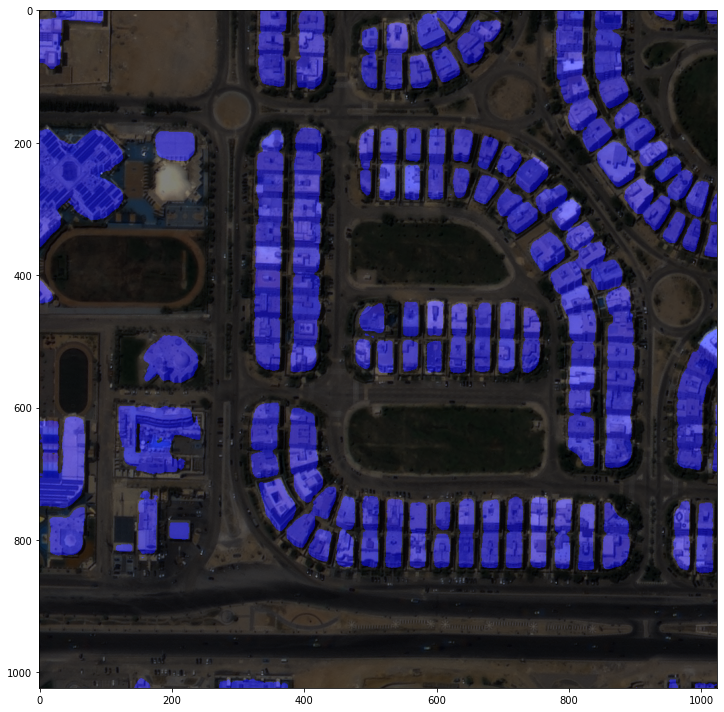

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00051_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


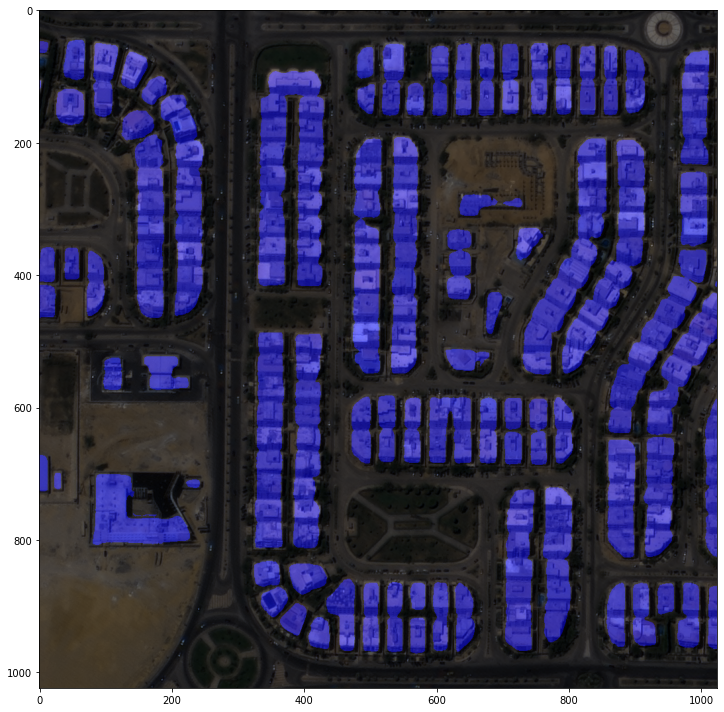

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00126_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


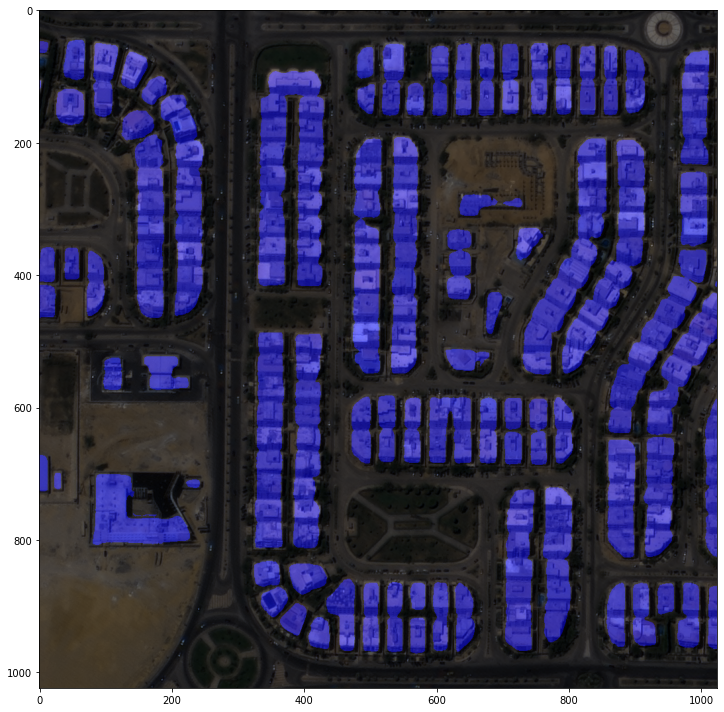

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00126_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


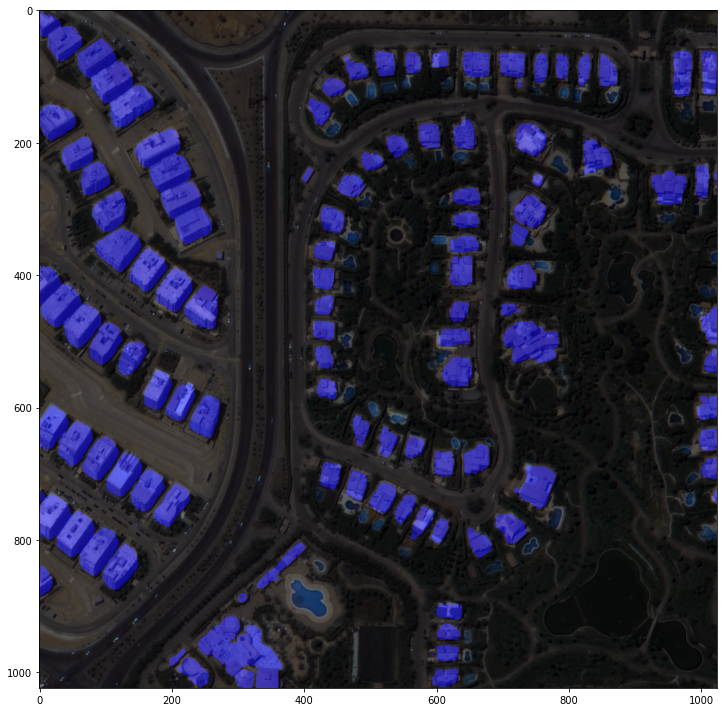

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00226_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


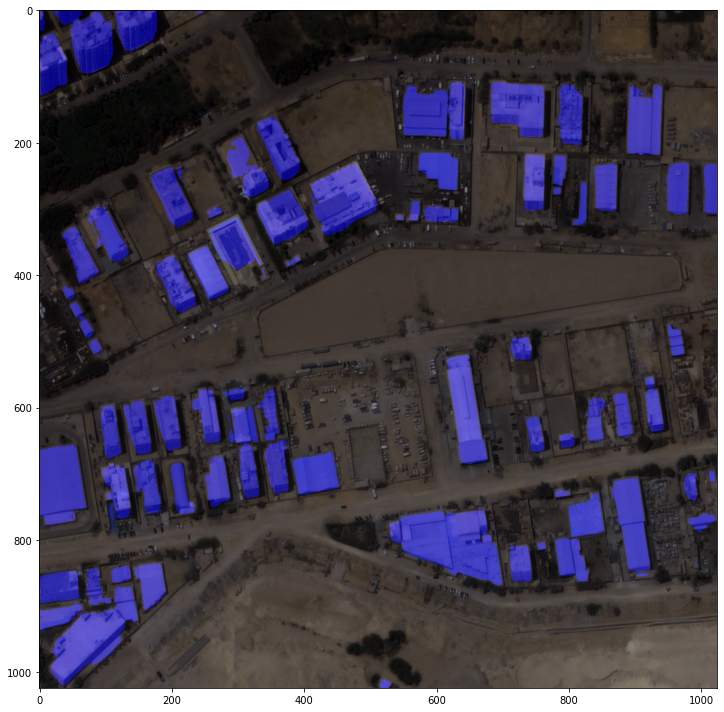

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00333_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

#### 네이버 지도 이미지로 테스트

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


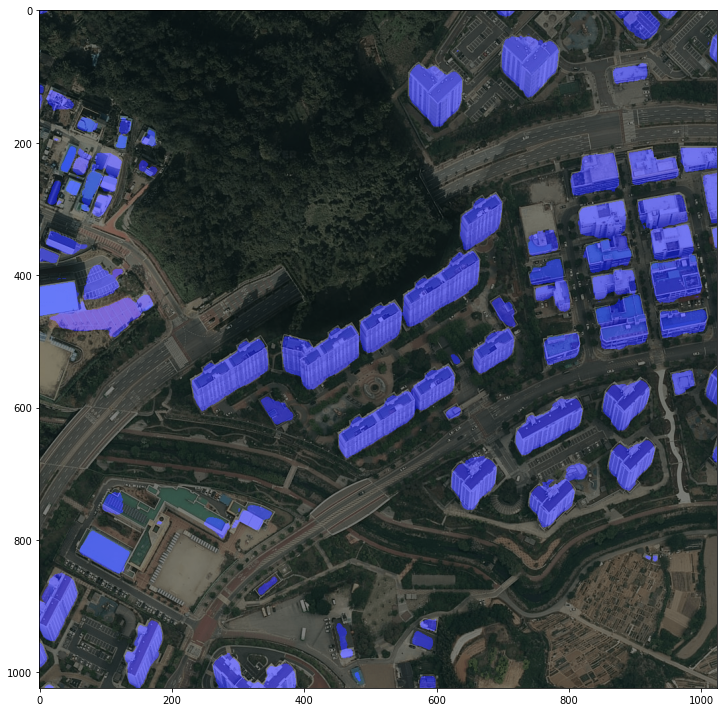

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0000.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


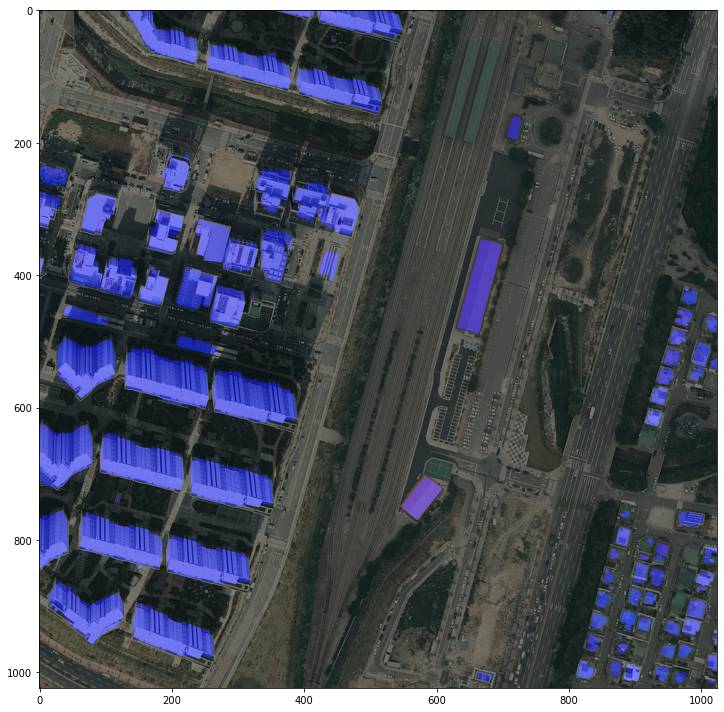

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0001.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


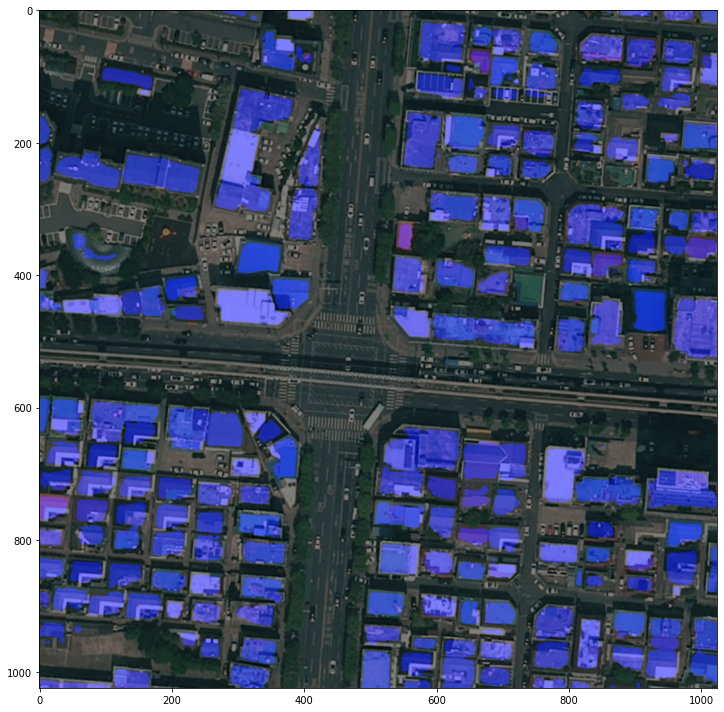

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0002.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)